# Compressing the System

## Overview

### Questions

* How do I compress the system to a target density? 
* What is a volume fraction?

### Objectives

* Show how to compute the **volume fraction** of a system.
* Explain how how an **Updater** is an **operation** that modifies the system when its **Trigger** returns `True`.
* Demonstrate using the **QuickCompress** updater to achieve a target volume fraction.
* Demonstrate using the **MoveSize** tuner to adjust the trial move size.

## Boilerplate Code

In [1]:
import math

import hoomd

In [2]:
import os

fn = os.path.join(os.getcwd(), "compressed.gsd")
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render a snapshot using **fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [3]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(
        scene, poly_info, N=snapshot.particles.N
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

## Volume Fraction

Self-assembly in hard particle systems typically occurs at a **volume fraction** above 0.5.
The **volume fraction** is the ratio of the volume occupied by the particles to the volume of the **periodic box**.

So far, this tutorial has **randomized** a system of *N* octahedra in a box with a very low volume fraction and stored that in `random.gsd`.
Initialize a **Simulation** with this configuration and see what volume fraction it is at:

In [4]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="random.gsd")

Compute the [volume of the octahedron](https://en.wikipedia.org/wiki/Octahedron):

In [5]:
a = math.sqrt(2) / 2
V_particle = 1 / 3 * math.sqrt(2) * a**3

Compute the **volume fraction**:

In [6]:
initial_volume_fraction = (
    simulation.state.N_particles * V_particle / simulation.state.box.volume
)
print(initial_volume_fraction)

0.05715592589579699


As you can see, this **volume fraction** is very low and the box volume needs to be significantly reduced to achieve a **volume fraction** above 0.5.

Use HPMC to move particles into non-overlapping configurations while you compress the system.
Set up the HPMC integrator for the octahedron simulations:

In [7]:
mc = hoomd.hpmc.integrate.ConvexPolyhedron()
mc.shape["octahedron"] = dict(
    vertices=[
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
)
simulation.operations.integrator = mc

## The QuickCompress Updater

An **Updater** is a type of **operation** in HOOMD-blue that makes changes to the **state**.
To use an **Updater**, first instantiate the object, assign a **Trigger**, and add it to the **Simulation**.
**Simulation** will apply the **Updater** on **time steps** where the **Trigger** returns `True`.
The **Periodic** trigger returns `True` every `period` steps.

**QuickCompress** is an **Updater** that works with HPMC to quickly compress the box to a target volume.
When triggered, **QuickCompress** reduces the box volume by a scale factor, while *allowing slight overlaps between the particles*.
It then waits for the translation and rotation **trial moves** to remove these overlaps before it reduces the volume again.
This process temporarily produces invalid system configurations, but is much quicker than a process that does not allow temporary overlaps.

Compute the final box size with a **volume fraction** above 0.5 and configure a **QuickCompress** to **trigger** every 10 **time steps**.

In [8]:
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)
final_volume_fraction = 0.57
final_box.volume = simulation.state.N_particles * V_particle / final_volume_fraction
compress = hoomd.hpmc.update.QuickCompress(
    trigger=hoomd.trigger.Periodic(10), target_box=final_box
)

Add the **Updater** to the **Simulation**:

In [9]:
simulation.operations.updaters.append(compress)

## The MoveSize Tuner

A **Tuner** is another type of **operation**.
**Tuners** make changes to other **operations** to improve performance.
In HPMC, the translation and rotation trial move sizes have a *huge* performance impact.
When the move size is too small it takes many time steps to make appreciable changes to the system.
When the move size is too large very few moves are accepted and it again takes many time steps to make appreciable changes.
The system makes the most progress at moderate move sizes and, in most cases, the optimal **acceptance ratio** is 20%.
The **MoveSize** tuner monitors the **acceptance ratio** and adjusts `d` and `a` to achieve the target.

The optimal move size depends on the density of the system.
**QuickCompress** changes the density rapidly during compression, so use the **MoveSize** tuner to adjust the move sizes regularly:

In [10]:
periodic = hoomd.trigger.Periodic(10)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=["a", "d"],
    target=0.2,
    trigger=periodic,
    max_translation_move=0.2,
    max_rotation_move=0.2,
)
simulation.operations.tuners.append(tune)

## Run Until Complete

When the **QuickCompress** updater achieves the target box size and there are no overlaps between particles, the compression process is **complete**.
The number of time steps needed to achieve this varies based on parameters.
Check the `compress.complete` property regularly and stop running the simulation when the compression completes:

In [11]:
while not compress.complete and simulation.timestep < 1e6:
    simulation.run(1000)

The `simulation.timestep < 1e6` check ensures that this while loop will not waste resources in cases where the compression will never complete.
The loop should complete before that point:

In [12]:
simulation.timestep

13000

Check to see if the compression completed successfully:

In [13]:
if not compress.complete:
    message = "Compression failed to complete"
    raise RuntimeError(message)

The **MoveSize** tuner should have adjusted the move sizes to relatively small values at the final density:

In [14]:
mc.a["octahedron"]

0.05877098349739833

In [15]:
mc.d["octahedron"]

0.0315257532691633

Now that the compression is complete, the particles are much closer together and not overlapping, but still arranged randomly.

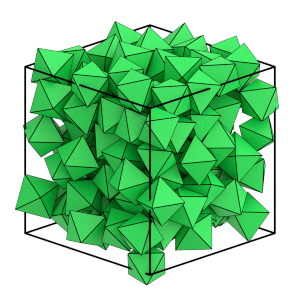

In [16]:
render(simulation.state.get_snapshot())

Save the final configuration to a GSD file for use in the next stage of the simulation:

In [17]:
hoomd.write.GSD.write(state=simulation.state, mode="xb", filename="compressed.gsd")